## Evaluation

In [1]:
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated
from langchain_ollama import ChatOllama
from langgraph.graph import START, MessagesState, StateGraph,END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from typing import Union, Dict
import json

formatter_llm = ChatOllama(model="jacob-ebey/phi4-tools:latest",base_url="192.168.23.138:11439")
class score(BaseModel):
    score1: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 1")
    score2: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 2")
    score3: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 3")
    score4: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 4")
    score5: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 5")

class JsonnedOutput(BaseModel):
    Accuracy: score = Field(...,description="ratings of the Accuracy in a probabilstic distribution manner")
    Completeness: score = Field(...,description="ratings of the Completeness in a probabilstic distribution manner")
    Clarity: score = Field(...,description="ratings of the Clarity in a probabilstic distribution manner")
    Safety:score = Field(...,description="ratings of the Safety in a probabilstic distribution manner")

def generate_evaluation_prompt(ground_truth: Dict, test_procedure: str) -> str:
    return f"""
        You are an expert evaluator assessing the accuracy, completeness, clarity, and safety of a scientific experiment procedure.

        ### **Task**
        Compare the **Test Procedure** against the **Ground Truth** and evaluate it across four key dimensions. Provide a **probability distribution over scores [1,2,3,4,5]** for each category.

        ### **Evaluation Criteria**
        1. **Accuracy**: Are the components and steps correct?
        2. **Completeness**: Are all critical steps present?
        3. **Clarity**: Is the procedure easy to follow?
        4. **Safety**: Are safety precautions included?

        ### **Response Format (Strict JSON)**
        ```json
        {{
            "Accuracy": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Completeness": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Clarity": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Safety": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }}
        }}
        Each probability value must be between 0 and 1 and sum to 1.

        ### **Ground Truth**
        {json.dumps(ground_truth, indent=4)}

        ### **Test Procedure**
        {test_procedure}
        """

formatter = formatter_llm.with_structured_output(JsonnedOutput,method='json_mode')
class State(TypedDict):
    input: str
    output: Union[JsonnedOutput,None]

workflow = StateGraph(state_schema=State)
def generate_graph_evaluation(state:State):
    # print(state["input"])
    response = formatter_llm.invoke(state["input"])
    # print(response)
    formatted_response = formatter.invoke(f"based on the {response.content} only output probabilities of each criteria and Leave everything. OUTPUT in the following json manner {{'Accuracy': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }}, 'Completeness': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }}, 'Clarity': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }},'Safety': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }} }} but ensure that the json format is correct")
    print(formatted_response)
    return {"output":{"Accuracy": formatted_response.Accuracy, "Completeness": formatted_response.Completeness,"Clarity":formatted_response.Clarity,"Safety": formatted_response.Safety}}

workflow.add_node("evaluator",generate_graph_evaluation)
workflow.add_edge(START,"evaluator")
workflow.add_edge("evaluator",END)
eval_grapgh = workflow.compile()
import os

def list_files_in_directory(directory):
    try:
        files = os.listdir(directory)
        return files
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
    except PermissionError:
        print(f"Permission denied to access the directory {directory}.")
from typing import Dict, Optional
def evaluate_experiment(title: str, ground_truth: Dict, test_procedure: str):
    prompt = generate_evaluation_prompt(ground_truth, test_procedure)


    for event in eval_grapgh.stream({"input": prompt, "output": None }):
        
    # Debug: Print the raw response to see what the model is returning
        try:
            return event['evaluator']['output']
        except KeyError:
            return event

    

In [22]:
import logging
import json
import re
import logging
from typing import Dict, Optional
from typing import TypedDict
import tqdm
# logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s: %(message)s")
# logger = logging.getLogger(__name__)

def load_json(filepath: str) -> Dict:
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            return json.load(file)
    except FileNotFoundError:
        # logger.error(f"File not found: {filepath}")
        print("file not found")
        raise
    except json.JSONDecodeError:
        # logger.error(f"Invalid JSON in file: {filepath}")
        print("file not found")
        raise
def extract_json_from_response(response_text: str) -> Optional[Dict]:
    try:
        json_match = re.search(r"\{.*\}", response_text, re.DOTALL)  # Extracts only JSON part
        if json_match:
            return json.loads(json_match.group())
        else:
            # logger.error("No valid JSON found in response.")
            print("file not found")
            return None
    except json.JSONDecodeError as e:
        # logger.error(f"JSON parsing error: {e}")
        print("file not found")
        return None

# class Plots(TypedDict):
#     experiment: list=[]
#     'Accuracy': list
#     Clarity: list=[]
#     Completeness: list=[]
#     Safety: list=[]

def run_evaluation(ground_truth_path: str, results_path: str, output_path: str,plots:dict):
    ground_truth_data = load_json(ground_truth_path)
    llm_generated_results = load_json(results_path)["experiments"]
    print(llm_generated_results)
    ground_truth_dict = {exp["title"]: exp for exp in ground_truth_data["experiments"]}
    evaluation_results = {}
    rewards = {}
    for chosen_exps in llm_generated_results:
        for title,test_procedure in chosen_exps.items():
            ground_truth = ground_truth_dict.get(title)

            if ground_truth:
                # logger.info(f"Evaluating: {title}")
                result = evaluate_experiment(title, ground_truth, test_procedure)
                # logger.info(result["Accuracy"].score1)
                for key,values in result.items():
                    # values
                    # print(values.score1)
                    # print(values.score2)
                    # print(values.score3)
                    # print(values.score4)
                    # print(values.score5)
                    plots.update({str(key):plots[key]+[1*float(values.score1)+2*float(values.score2)+3*float(values.score3)+4*float(values.score4)+5*float(values.score5)]})
                # if result:
                #     evaluation_results[title] = result
                #     rewards[title] = calculate_reward(result)
    output_data = {
        "evaluations": evaluation_results,
        "rewards": rewards
    }
    with open(output_path, "w", encoding="utf-8") as file:
        json.dump(output_data, file, indent=4, ensure_ascii=False)

    # logger.info(f"Evaluation complete! Results saved to '{output_path}'.")
    return plots

exp_found_dir = 'phi4_exps_w_feedback' # name of the directory where exps can be found to evaluate

exps = list_files_in_directory(exp_found_dir)
samples_plot = []
for evaluations in tqdm.tqdm(exps):
    plots = {'Accuracy':[],'Clarity':[],'Completeness':[],'Safety':[]}
    samples_plot.append(run_evaluation(
        ground_truth_path="non_code_files/experiments_2.json",
        results_path=exp_found_dir+"/"+evaluations,
        output_path="evaluation_results.json",
        plots=plots
    ))
    
    

# [print(plotings) for plotings in samples_plot]

  0%|          | 0/1 [00:00<?, ?it/s]

[{"To verify the relationship between voltage (V), current (I), and resistance (R) in an electrical circuit, as expressed by Ohm's Law: V=IRV = IRV=IR": "To conduct an experiment verifying Ohm's Law, which states \\( V = IR \\), you will need specific materials and follow a detailed procedure. Here is the information organized into required sections:\n\n### Experiment Materials:\n1. **Power Supply**: A battery or DC power supply to provide variable voltage.\n2. **Resistor(s)**: One or more resistors with known resistance values.\n3. **Ammeter**: To measure the current flowing through the circuit.\n4. **Voltmeter**: To measure the potential difference across the resistor.\n5. **Connecting Wires**: Insulated copper wires for making connections.\n6. **Switch (optional)**: To easily open and close the circuit.\n\n### Experiment Steps:\n1. **Setup the Circuit**:\n   - Connect the power supply, ammeter, resistor, and voltmeter in series to form a complete circuit.\n   - Ensure that the posit

100%|██████████| 1/1 [03:37<00:00, 217.91s/it]

Accuracy=score(score1=0.05, score2=0.1, score3=0.25, score4=0.4, score5=0.2) Completeness=score(score1=0.0, score2=0.05, score3=0.15, score4=0.5, score5=0.3) Clarity=score(score1=0.0, score2=0.1, score3=0.2, score4=0.4, score5=0.3) Safety=score(score1=0.05, score2=0.15, score3=0.25, score4=0.35, score5=0.2)


In [13]:
#file name where to save the result CAUTION the results saved are in form of a list hence it assumes that first experiment results will be of first experiment when later it is plotted so if experiments in the result files are in revrsed order then replace the F.write(sample_plot) with F.write(sample_plot[::-1])
save_results_file = "GT.txt"
with open(save_results_file,'w') as F:
    F.write(str(samples_plot))

## Graphs

In [19]:
with open("GT.txt", "r") as file:
        content = file.read()
        data = ast.literal_eval(content)

type(data)

dict

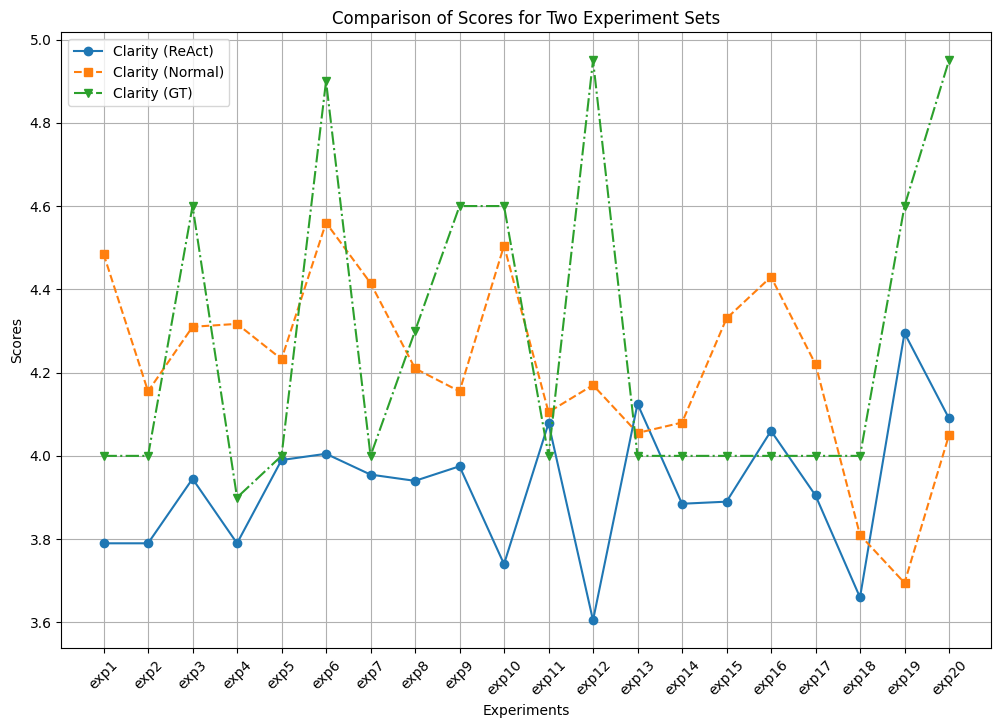

In [27]:


import ast
import torch
import matplotlib.pyplot as plt

# Function to read and process data
def process_data(filename):
    with open(filename, "r") as file:
        content = file.read()
        data = ast.literal_eval(content)
    
    completeness, accuracy, safety, clarity = [], [], [], []
    if type(data) == list:
        for i in data:
            completeness.append(i['Completeness'])
            accuracy.append(i['Accuracy'])
            safety.append(i['Clarity'])
            clarity.append(i['Safety'])
        
        return (
            torch.tensor(accuracy).mean(dim=0).numpy(),
            torch.tensor(completeness).mean(dim=0).numpy(),
            torch.tensor(safety).mean(dim=0).numpy(),
            torch.tensor(clarity).mean(dim=0).numpy()
        )
    elif type(data)==dict:
        return (
            torch.tensor(data['Completeness']).numpy(),
            torch.tensor(data['Accuracy']).numpy(),
            torch.tensor(data['Clarity']).numpy(),
            torch.tensor(data['Safety']).numpy()
        )
# Process both datasets
acc_1, comp_1, safe_1, clar_1 = process_data("Phi4_20Exps.txt")
acc_2, comp_2, safe_2, clar_2 = process_data("Phi4_20Exps_normal.txt")
acc_3, comp_3,safe_3,clar_3 = process_data("Using_phi4_for_groundT.txt")

# Define x-axis labels
x_labels = [f'exp{i+1}' for i in range(20)]

# Plot the scores
plt.figure(figsize=(12, 8))

# First dataset
# plt.plot(x_labels, acc_1, label='Accuracy (ReAct)', marker='o', linestyle='-')
# plt.plot(x_labels, comp_1, label='Completeness (ReAct)', marker='o', linestyle='-')
# plt.plot(x_labels, safe_1, label='Safety (ReAct)', marker='o', linestyle='-')
plt.plot(x_labels, clar_1, label='Clarity (ReAct)', marker='o', linestyle='-')

# Second dataset
# plt.plot(x_labels, acc_2, label='Accuracy (Normal)', marker='s', linestyle='--')
# plt.plot(x_labels, comp_2, label='Completeness (Normal)', marker='s', linestyle='--')
# plt.plot(x_labels, safe_2, label='Safety (Normal)', marker='s', linestyle='--')
plt.plot(x_labels, clar_2, label='Clarity (Normal)', marker='s', linestyle='--')

# plt.plot(x_labels, acc_3, label='Accuracy (GT)', marker='v', linestyle='-.')
# plt.plot(x_labels, comp_3, label='Completeness (GT)', marker='v', linestyle='-.')
# plt.plot(x_labels, safe_3, label='Safety (GT)', marker='v', linestyle='-.')
plt.plot(x_labels, clar_3, label='Clarity (GT)', marker='v', linestyle='-.')

# Formatting
plt.xlabel('Experiments')
plt.ylabel('Scores')
plt.title('Comparison of Scores for Two Experiment Sets')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.show()


In [9]:
samples_plot[0]["Accuracy"]

[3.75,
 3.6,
 3.6,
 4.1,
 4.95,
 3.6,
 3.8,
 3.6,
 3.6,
 3.4,
 3.5,
 3.6,
 3.5,
 3.6,
 3.6,
 3.5,
 4.0,
 3.55,
 3.5,
 3.9]

torch.Size([4, 20])
torch.Size([4, 20])
torch.Size([4, 20])
torch.Size([4, 20])


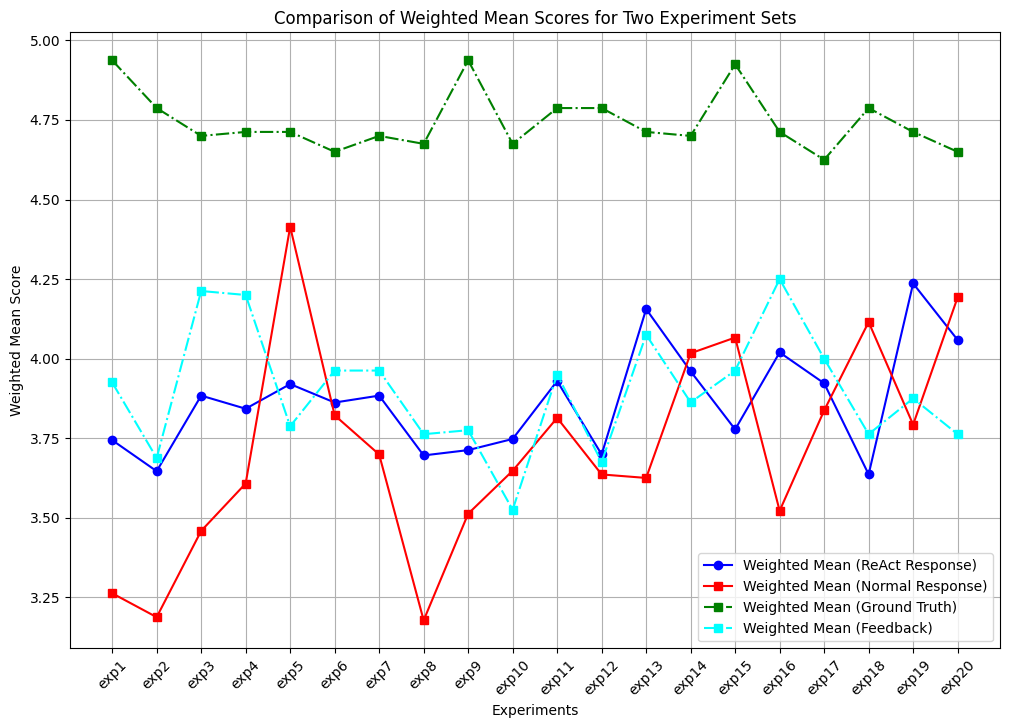

In [23]:
import ast
import torch
import matplotlib.pyplot as plt

def process_data(filename, reverse=False,mode=False):
    
    if mode:
        completeness,accuracy,safety,clarity = torch.tensor(samples_plot[0]['Completeness']),torch.tensor(samples_plot[0]['Accuracy']),torch.tensor(samples_plot[0]['Safety']),torch.tensor(samples_plot[0]['Clarity'])
    else:
        with open(filename, "r") as file:
            content = file.read()
            data = ast.literal_eval(content)
        
        completeness, accuracy, safety, clarity = [], [], [], []
        if isinstance(data, list):
            for i in data:
                completeness.append(i['Completeness'])
                accuracy.append(i['Accuracy'])
                safety.append(i['Clarity'])
                clarity.append(i['Safety'])
            completeness = torch.tensor(completeness).mean(dim=0)
            accuracy = torch.tensor(accuracy).mean(dim=0)
            safety = torch.tensor(safety).mean(dim=0)
            clarity = torch.tensor(clarity).mean(dim=0)
        elif isinstance(data, dict):
            completeness = torch.tensor(data['Completeness'])
            accuracy = torch.tensor(data['Accuracy'])
            safety = torch.tensor(data['Clarity'])
            clarity = torch.tensor(data['Safety'])
        
    if reverse:
        stacked_tensors = torch.stack([
            accuracy.flip(dims=(0,)),
            completeness.flip(dims=(0,)),
            safety.flip(dims=(0,)),
            clarity.flip(dims=(0,))
        ])
    else:
        stacked_tensors = torch.stack([
            accuracy,
            completeness,
            safety,
            clarity
        ])
    
    weights = torch.tensor([1,1,1,1])
    normalized_weights = weights / weights.sum()
    weighted_mean = torch.mean(stacked_tensors * weights[:, None], dim=0)
    print(stacked_tensors.shape)
    return weighted_mean.numpy()

# Process both datasets
weighted_mean_1 = process_data("non_code_files/Phi4_20Exps.txt")
weighted_mean_2 = process_data("non_code_files/Phi4_20Exps_normal.txt", reverse=True)
weighted_mean_3 = process_data("non_code_files/Using_phi4_for_groundT.txt",reverse=True)
weighted_mean_4 = process_data("",mode=True)

# Define x-axis labels
x_labels = [f'exp{i+1}' for i in range(20)]

# Plot the weighted mean scores
plt.figure(figsize=(12, 8))

plt.plot(x_labels, weighted_mean_1, marker='o', linestyle='-', color='blue', label='Weighted Mean (ReAct Response)')
plt.plot(x_labels, weighted_mean_2, marker='s', linestyle='-', color='red', label='Weighted Mean (Normal Response)')
plt.plot(x_labels, weighted_mean_3, marker='s', linestyle='-.', color='green', label='Weighted Mean (Ground Truth)')
plt.plot(x_labels, weighted_mean_4, marker='s', linestyle='-.', color='cyan', label='Weighted Mean (Feedback)')

# Formatting
plt.xlabel('Experiments')
plt.ylabel('Weighted Mean Score')
plt.title('Comparison of Weighted Mean Scores for Two Experiment Sets')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Save plot
plt.savefig('phi4_20_exps_comparative_mean_reward.png')

# Show plot
plt.show()

In [12]:
samples_plot = {'Accuracy': [3.75, 3.9000000000000004, 4.1, 3.8000000000000003, 3.0000000000000004, 3.9000000000000004, 3.65, 4.1, 3.85, 3.75, 3.5, 3.0000000000000004, 3.9000000000000004, 3.8000000000000003, 3.9499999999999997, 3.9499999999999997, 4.2, 4.05, 3.9000000000000004, 3.8000000000000003], 'Clarity': [3.75, 4.0, 4.0, 3.9000000000000004, 3.0000000000000004, 4.0, 3.65, 4.0, 3.75, 3.75, 3.5, 3.0000000000000004, 4.0, 3.8000000000000003, 3.85, 3.9499999999999997, 4.2, 4.05, 3.8000000000000003, 3.9499999999999997], 'Completeness': [3.75, 3.9000000000000004, 4.1, 3.9000000000000004, 3.05, 3.9000000000000004, 3.65, 3.9000000000000004, 3.85, 3.75, 3.65, 3.05, 3.95, 3.8000000000000003, 3.8, 3.7, 4.1, 4.1, 3.9000000000000004, 3.9000000000000004], 'Safety': [1.65, 2.1, 1.1, 1.8, 2.1, 1.9000000000000001, 1.25, 1.1, 3.45, 1.25, 1.45, 2.3, 1.5, 2.45, 1.25, 1.4700000000000002, 1.2000000000000002, 1.3599999999999999, 1.2000000000000002, 2.2]}

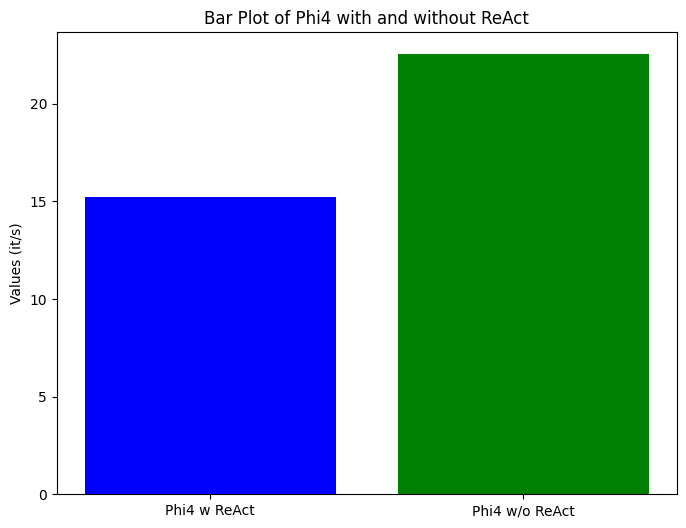

In [12]:
import matplotlib.pyplot as plt

# Data and labels
data = [15.23, 22.54]
labels = ['Phi4 w ReAct', 'Phi4 w/o ReAct']

# Plotting the bar plot with different colors
colors = ['blue', 'green']
plt.figure(figsize=(8, 6))
plt.bar(labels, data, color=colors)
plt.ylabel('Values (it/s)')
plt.title('Bar Plot of Phi4 with and without ReAct')
plt.show()